In [1]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import Trainer
from qml_contrastive.models.hybrid.contrastive import MNISTSupContrast, MNISTClassify
from qml_contrastive.utils import generate_embeddings, vmf_kde_on_circle, pca_proj, tsne_proj, plot_training

import matplotlib.pyplot as plt

plt.style.use('ggplot')

## MNIST Dataset

In [ ]:
from qml_contrastive.data_mnist import load_mnist_data

classes = (0, 1, 2, 3, 4, 5, 6)
reduced_dim = 10
dataset_size = (4000, 1000)

mnist_data = load_mnist_data(classes=classes, reduced_dim = reduced_dim, dataset_size=dataset_size, data_dir="../data/")

def create_data_loader(data, labels, batch_size=64, shuffle=True, num_workers=4):
    print(data)
    print(labels)
    dataset = TensorDataset(data, labels)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    return data_loader

train_loader = create_data_loader(mnist_data["train_data"], mnist_data["train_labels"])
val_loader = create_data_loader(mnist_data["test_data"], mnist_data["test_labels"], shuffle=False)

tensor([[[[0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.2275, 0.1137, 0.0000],
          [0.0039, 0.0000, 0.1059,  ..., 0.5412, 0.1922, 0.0000],
          ...,
          [0.0039, 0.0000, 0.0667,  ..., 0.0078, 0.0039, 0.0000],
          [0.0039, 0.2000, 0.7216,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0353, 0.0549,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0118,  ..., 0.4235, 0.0000, 0.0118],
          ...,
          [0.0118, 0.0000, 0.6275,  ..., 0.0000, 0.0118, 0.0000],
          [0.0039, 0.0000, 0.1255,  ..., 0.0118, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0824, 0.0196, 0.0000],
          [0.0000, 0.2235, 0.1020,  ..

/home/ubuntu20_1/Projects_Ubuntu20/gsoc24/qml-hep/gsoc24-qml-workspace/src/qml_contrastive/utils.py:61: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=labels, palette=sns.color_palette("tab10")).set(title="PCA")


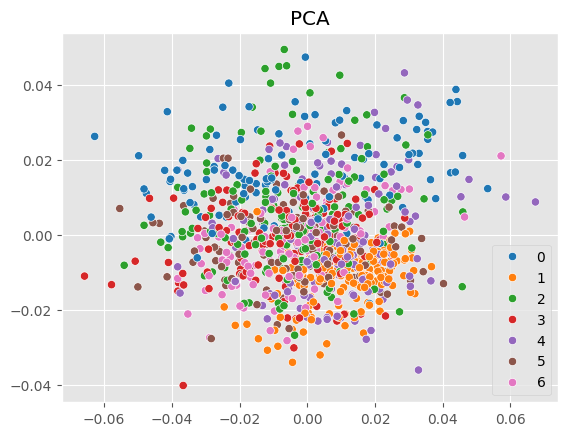

/home/ubuntu20_1/Projects_Ubuntu20/gsoc24/qml-hep/gsoc24-qml-workspace/src/qml_contrastive/utils.py:74: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=labels, palette=sns.color_palette("tab10")).set(title="T-SNE")


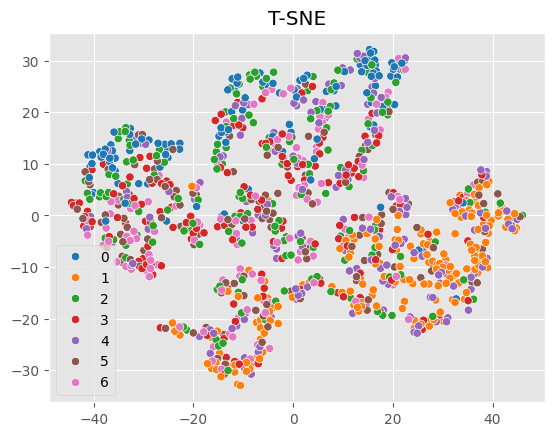

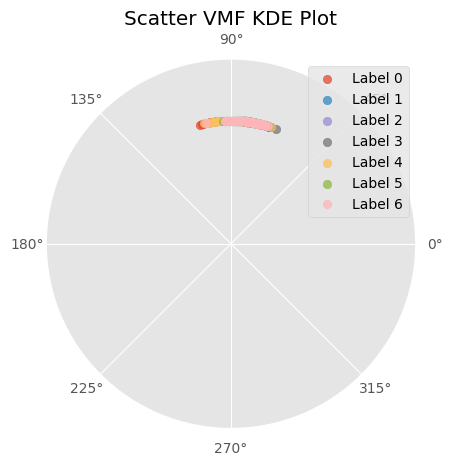

/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoin

Epoch 19: 100%|██████████| 79/79 [00:01<00:00, 47.99it/s, loss=0.443, v_num=0, val_loss=0.589, train_loss=0.468]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 79/79 [00:01<00:00, 47.56it/s, loss=0.443, v_num=0, val_loss=0.589, train_loss=0.468]


/home/ubuntu20_1/Projects_Ubuntu20/gsoc24/qml-hep/gsoc24-qml-workspace/src/qml_contrastive/utils.py:61: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=labels, palette=sns.color_palette("tab10")).set(title="PCA")


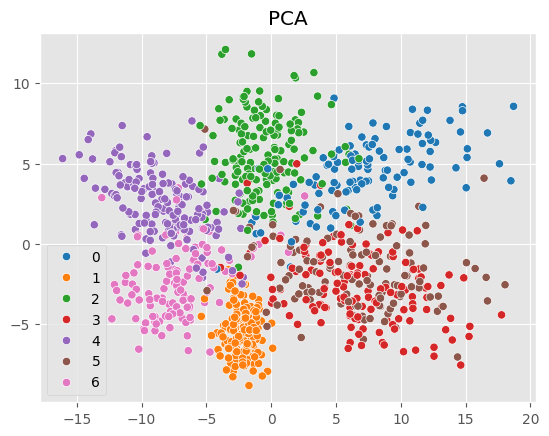

/home/ubuntu20_1/Projects_Ubuntu20/gsoc24/qml-hep/gsoc24-qml-workspace/src/qml_contrastive/utils.py:74: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=labels, palette=sns.color_palette("tab10")).set(title="T-SNE")


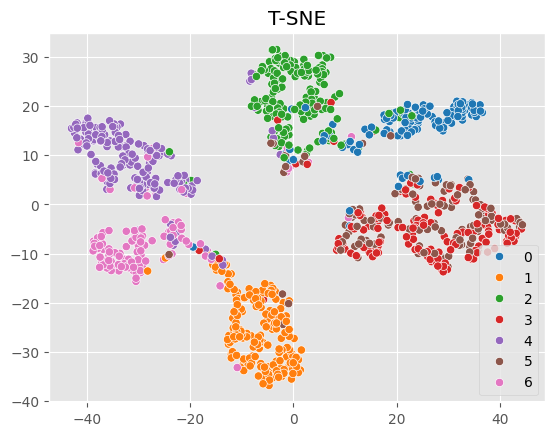

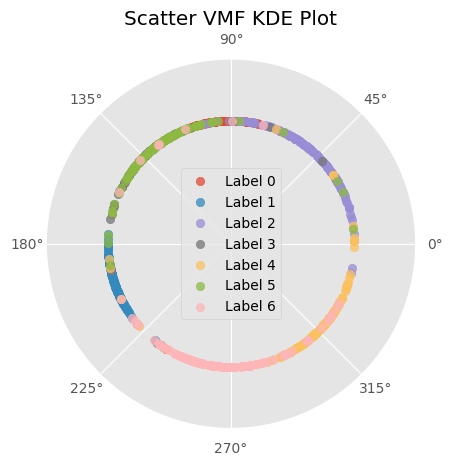

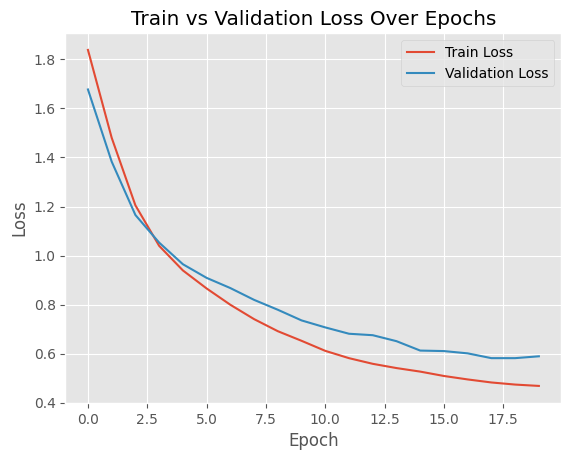

In [2]:
model = MNISTClassify(activ_type="relu", pool_type="max", head_output=2, classes=classes, lr=1e-3)

# Plot embeddings before training
embeddings, labels = generate_embeddings(model, val_loader)
pca_proj(embeddings, labels)
tsne_proj(embeddings, labels)
vmf_kde_on_circle(embeddings, labels)

# Training the model
logger = CSVLogger(save_dir="logs/", name="MNISTContrast", version=0)
trainer = Trainer(max_epochs=20, logger=logger, gpus=1 if torch.cuda.is_available() else 0)
trainer.fit(model, train_loader, val_loader)

# Plot embeddings after training
embeddings, labels = generate_embeddings(model, val_loader)
pca_proj(embeddings, labels)
tsne_proj(embeddings, labels)
vmf_kde_on_circle(embeddings, labels)

plot_training(logger.log_dir)

/home/ubuntu20_1/Projects_Ubuntu20/gsoc24/qml-hep/gsoc24-qml-workspace/src/qml_contrastive/utils.py:61: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=labels, palette=sns.color_palette("tab10")).set(title="PCA")


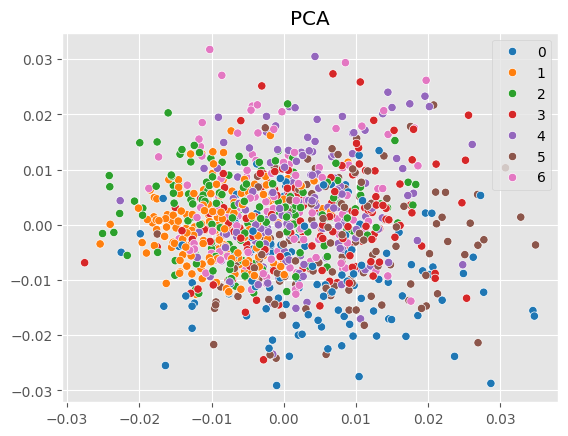

/home/ubuntu20_1/Projects_Ubuntu20/gsoc24/qml-hep/gsoc24-qml-workspace/src/qml_contrastive/utils.py:74: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=labels, palette=sns.color_palette("tab10")).set(title="T-SNE")


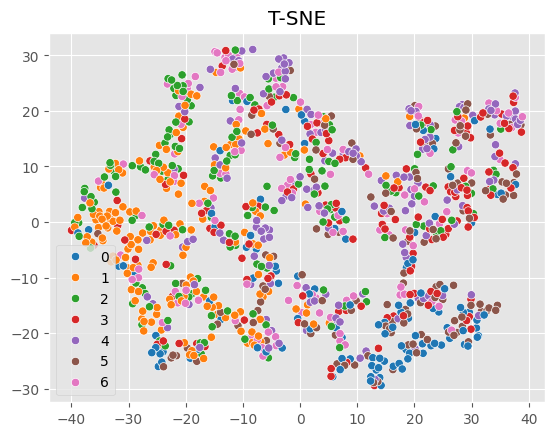

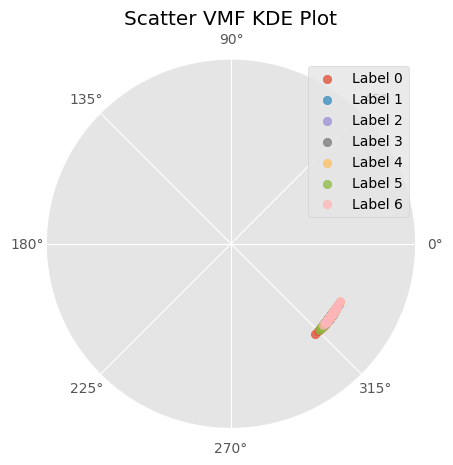

/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoin

Epoch 19: 100%|██████████| 79/79 [00:01<00:00, 45.20it/s, loss=0.759, v_num=0, val_loss=0.847, train_loss=0.761]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 79/79 [00:01<00:00, 44.83it/s, loss=0.759, v_num=0, val_loss=0.847, train_loss=0.761]


/home/ubuntu20_1/Projects_Ubuntu20/gsoc24/qml-hep/gsoc24-qml-workspace/src/qml_contrastive/utils.py:61: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=labels, palette=sns.color_palette("tab10")).set(title="PCA")


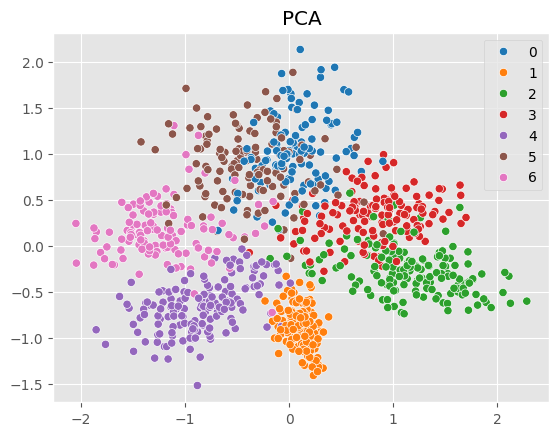

/home/ubuntu20_1/Projects_Ubuntu20/gsoc24/qml-hep/gsoc24-qml-workspace/src/qml_contrastive/utils.py:74: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=labels, palette=sns.color_palette("tab10")).set(title="T-SNE")


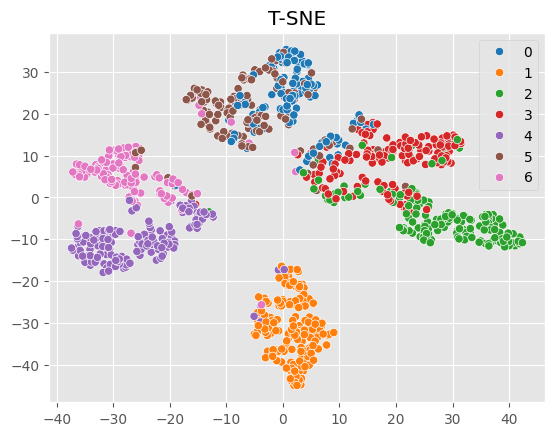

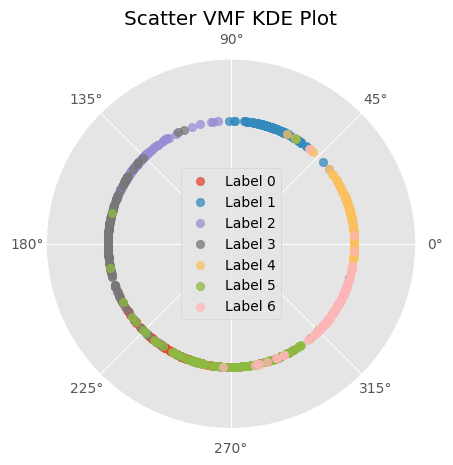

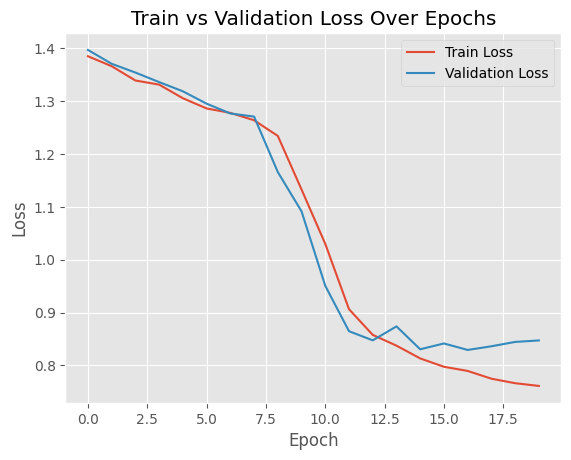

In [3]:
model = MNISTSupContrast(activ_type="relu", pool_type="max", head_output=2, lr=1e-3)
# model = MNISTClassify(activ_type="relu", pool_type="max", head_output=2, classes=classes, lr=1e-3)

# Plot embeddings before training
embeddings, labels = generate_embeddings(model, val_loader)
pca_proj(embeddings, labels)
tsne_proj(embeddings, labels)
vmf_kde_on_circle(embeddings, labels)

# Training the model
logger = CSVLogger(save_dir="logs/", name="MNISTContrast", version=0)
trainer = Trainer(max_epochs=20, logger=logger, gpus=1 if torch.cuda.is_available() else 0)
trainer.fit(model, train_loader, val_loader)

# Plot embeddings after training
embeddings, labels = generate_embeddings(model, val_loader)
pca_proj(embeddings, labels)
tsne_proj(embeddings, labels)
vmf_kde_on_circle(embeddings, labels)

plot_training(logger.log_dir)

## Photon-Electron Dataset

In [1]:
from qml_contrastive.data_pe import *

electron_file = "../data/PhotonElectron/electron.hdf5"
photon_file = "../data/PhotonElectron/photon.hdf5"

inspect_h5py_file(electron_file)
inspect_h5py_file(photon_file)

Inspecting HDF5 file: ../data/PhotonElectron/electron.hdf5
Name: X
    Shape: (249000, 32, 32, 2)
    Dtype: float32
Name: y
    Shape: (249000,)
    Dtype: float32
Inspecting HDF5 file: ../data/PhotonElectron/photon.hdf5
Name: X
    Shape: (249000, 32, 32, 2)
    Dtype: float32
Name: y
    Shape: (249000,)
    Dtype: float32


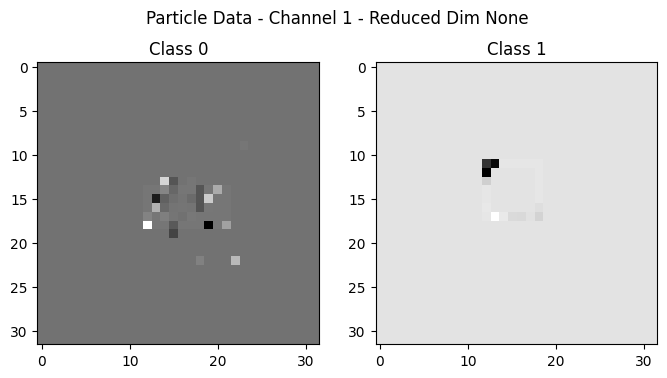

In [2]:
reduced_dim = None
dataset_size = 1000
channel = 1

# Load and preprocess the particle data
particle_data = load_pe_data(electron_file, photon_file, reduced_dim=reduced_dim, dataset_size=dataset_size, channel=channel)

# Visualize the preprocessed images
train_data = particle_data["train_dataset"].data
train_labels = particle_data["train_dataset"].labels
visualize_data(train_data, train_labels, classes=(0, 1), title=f"Particle Data - Channel {channel} - Reduced Dim {reduced_dim}")

In [3]:
reduced_dim = None
dataset_size = 1000
channel = 0

# Load and preprocess the particle data
particle_data = load_pe_data(electron_file, photon_file, reduced_dim=reduced_dim, dataset_size=dataset_size, channel=channel)

# Visualize the preprocessed images
train_data = particle_data["train_dataset"].data
train_labels = particle_data["train_dataset"].labels
visualize_data(train_data, train_labels, classes=(0, 1), title=f"Particle Data - Channel {channel} - Reduced Dim {reduced_dim}")

NameError: name 'load_pe_data' is not defined

In [ ]:
reduced_dim = 10
dataset_size = 10000
channel = 1

# Load and preprocess the particle data
particle_data = load_pe_data(electron_file, photon_file, reduced_dim=reduced_dim, dataset_size=dataset_size, channel=channel)

# Visualize the preprocessed images
train_data = particle_data["train_dataset"].data
train_labels = particle_data["train_dataset"].labels
visualize_data(train_data, train_labels, classes=(0, 1), title=f"Particle Data - Channel {channel} - Reduced Dim {reduced_dim}")

In [ ]:
classes = (0, 1)

train_loader = create_data_loader(particle_data["train_dataset"].data, particle_data["train_dataset"].labels)
val_loader = create_data_loader(particle_data["val_dataset"].data, particle_data["val_dataset"].labels, shuffle=False)

# model = MNISTSupContrast(activ_type="relu", pool_type="max", head_output=2, lr=1e-3)
model = MNISTClassify(activ_type="relu", pool_type="max", head_output=2, classes=classes, lr=1e-3)

# Plot embeddings before training
embeddings, labels = generate_embeddings(model, val_loader)
pca_proj(embeddings, labels)
# tsne_proj(embeddings, labels)
vmf_kde_on_circle(embeddings, labels)

# Training the model
logger = CSVLogger(save_dir="logs/", name="MNISTContrast", version=0)
trainer = Trainer(max_epochs=20, logger=logger, gpus=1 if torch.cuda.is_available() else 0)
trainer.fit(model, train_loader, val_loader)

# Plot embeddings after training
embeddings, labels = generate_embeddings(model, val_loader)
pca_proj(embeddings, labels)
# tsne_proj(embeddings, labels)
vmf_kde_on_circle(embeddings, labels)

In [ ]:
reduced_dim = 10
dataset_size = 100000
channel = 0

# Load and preprocess the particle data
particle_data = load_pe_data(electron_file, photon_file, reduced_dim=reduced_dim, dataset_size=dataset_size, channel=channel)

# Visualize the preprocessed images
train_data = particle_data["train_dataset"].data
train_labels = particle_data["train_dataset"].labels
visualize_data(train_data, train_labels, classes=(0, 1), title=f"Particle Data - Channel {channel} - Reduced Dim {reduced_dim}")

In [ ]:
classes = (0, 1)

train_loader = create_data_loader(particle_data["train_dataset"].data, particle_data["train_dataset"].labels)
val_loader = create_data_loader(particle_data["val_dataset"].data, particle_data["val_dataset"].labels, shuffle=False)

model = MNISTSupContrast(activ_type="relu", pool_type="max", head_output=2, lr=1e-3)

# Plot embeddings before training
embeddings, labels = generate_embeddings(model, val_loader)
pca_proj(embeddings, labels)
# tsne_proj(embeddings, labels)
vmf_kde_on_circle(embeddings, labels)

# Training the model
logger = CSVLogger(save_dir="logs/", name="MNISTClassify", version=0)
trainer = Trainer(max_epochs=20, logger=logger, gpus=1 if torch.cuda.is_available() else 0)
trainer.fit(model, train_loader, val_loader)

# Plot embeddings after training
embeddings, labels = generate_embeddings(model, val_loader)
pca_proj(embeddings, labels)
# tsne_proj(embeddings, labels)
vmf_kde_on_circle(embeddings, labels)